# Imports:

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree


# Opening train and test data

In [100]:
X_train_nn=pd.read_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_train_nn.csv')
X_test_nn=pd.read_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_test_nn.csv')

y_train=pd.read_csv("/workspaces/Decis_Tree_Diabetes/data/processed/y_train.txt", header=None)
y_test=pd.read_csv("/workspaces/Decis_Tree_Diabetes/data/processed/y_test.txt", header=None)
#the code above imports y as dataframe, below I convert it to a pd series
y_train=y_train[0]
y_test=y_test[0]

# Optimised decision tree model

Below is the estimation of the optimised decision tree model and its performance metrics are stored to later compare them with the random forest model

In [101]:
dec_tree_opt=load(open('/workspaces/Decis_Tree_Diabetes/models/dt_log_loss_depth3_minsampl3_seed42.pk', 'rb'))
dec_tree_opt.fit(X_train_nn, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=3, min_samples_split=3,
                       random_state=42)

In [102]:
y_pred = dec_tree_opt.predict(X_test_nn)

## Evaluating model performance

Accuracy:

In [103]:
acc_dec_tree=accuracy_score(y_pred,y_test)

Confusion matrix:

In [104]:
dec_tree_cm = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )

Classification report:

In [105]:
class_report_dt=metrics.classification_report(y_test, y_pred)

# Random forest - Baseline

In [106]:

rf_base=RandomForestClassifier(random_state=42)
rf_base.fit(X_train_nn, y_train)

RandomForestClassifier(random_state=42)

In [107]:
y_pred_train=rf_base.predict(X_train_nn)
y_pred=rf_base.predict(X_test_nn)

## Model performance

Accuracy train vs test data:

The baseline model suggests there is overfitting since the accuracy of the training data is higher than the test data. Neverthless, the baseline accuracy of the random forest is 75%, which is not too low considering this is the baseline model. 

In [108]:
rf_acc_base=accuracy_score(y_pred,y_test)
rf_acc_train=accuracy_score(y_pred_train,y_train)
print('Random forest - Accuracy train: ', rf_acc_train)
print('Random forest - Accuracy test: ', rf_acc_base )

Random forest - Accuracy train:  1.0
Random forest - Accuracy test:  0.7532467532467533


Accuracy optimised decision tree versus baseline random forest:

The accuracy of the baseline random forest (RF) is similar to that of the optimised decision tree (DT). This result corroborates the aim of a random forest, e.g., by generating multiple DTs, the RF obtains a more accurate output. Hence why the non-optimal RF reaches a similar accurate to the optimised DT model. 

In [109]:
print('Random forest baseline accuracy: ', rf_acc_base )
print('Decision tree, optimised, accuracy: ', acc_dec_tree )

Random forest baseline accuracy:  0.7532467532467533
Decision tree, optimised, accuracy:  0.7662337662337663


Storing classification report to later compare it with optimised model

In [110]:
rf_class_rep_base=metrics.classification_report(y_test, y_pred)

# Hyperparameter tunning

Setting hyperparameters, randomised search, and fitting model

In [111]:
hyprms={
    'n_estimators': np.arange(1,100,1),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': np.linspace(0.01, 1, 100, endpoint=False),
    'min_samples_leaf': np.linspace(0.01, 1, 100, endpoint=False),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_depth': np.arange(1,80,1)

}
score=['accuracy', 'f1']

In [112]:
rf_opt=RandomizedSearchCV(rf_base, hyprms, scoring='accuracy', refit=True,n_iter = 500, cv = 5, random_state = 42)

In [113]:
rf_opt.fit(X_train_nn,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=500,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56...
       0.9604, 0.9703, 0.9802, 0.9901]),
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42, scoring='accuracy')

In [114]:
#Storing Grid search results as dataframe
result=pd.DataFrame(rf_opt.cv_results_)

to_rename = {'param_n_estimators': "n_estimators", 
    'param_min_samples_split': 'min_samples_split',
       'param_min_samples_leaf': 'min_samples_leaf', 
       'param_max_depth': 'max_depth'}

result.rename(columns=to_rename, inplace=True)# Rename the columns

**Graph accuracy vs hyperparameters:**

*   Number of trees: the relationship is non-linear, it is not clear from the graph whether more trees in the model are associated with higher accuracy, at least for this training data. 

*   Min N required to split: a higher percentange of the minimum sample required for the model to make the split is associated with lower accuracy. In other words, a higher sample size required to split a node is associated with lower accuracy

*   Min N within leaf: a higher percentange of the minimum sample required within a leaf is associated with lower accuracy. In other words, a higher sample size required within a leaf is associated with lower accuracy. The peak decline in accuracy approximately occurs after 0.3

*   Maximum depth: it seems like the maximum depth follows an inverse parabolic relationsip with accuracy, meaning that, in very low or very high values of maximum depth, accuracy seems to be lower. In contrast, within middle values of maximum depth, accuracy is higher

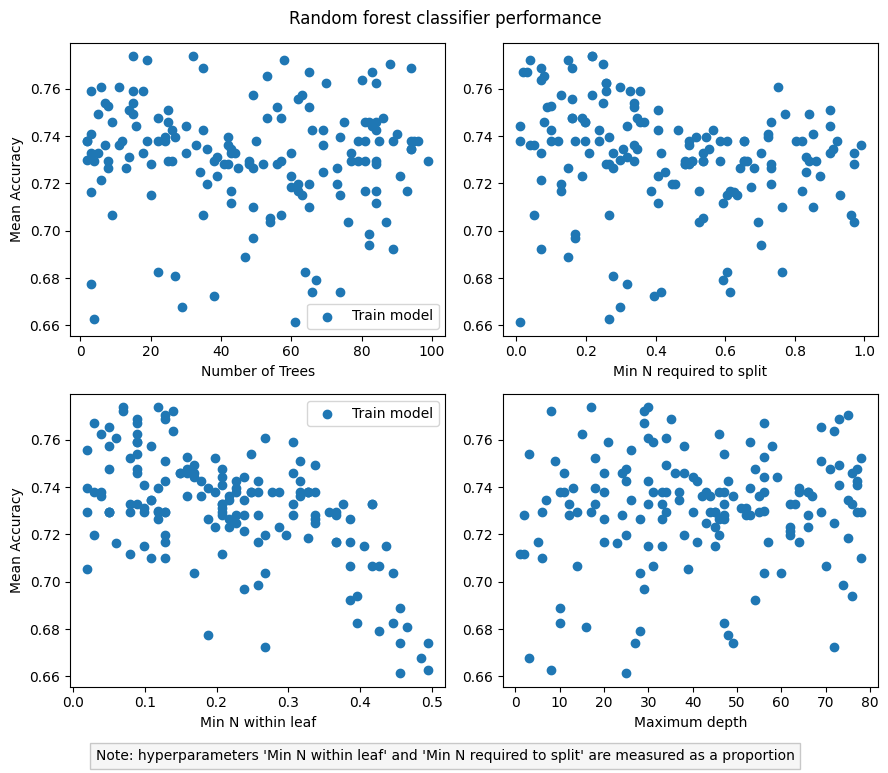

In [116]:
#Here I exclude hyperparameters with accuraccy score <0.66 due to data visualisation purposes
metrics2=result[result['mean_test_score']>=0.66]

fig, ax = plt.subplots(2,2, figsize=(9,7.5))

ax[0,0].scatter(metrics2['n_estimators'], metrics2['mean_test_score'], label='Train model')
ax[0,0].set_ylabel('Mean Accuracy')
ax[0,0].set_xlabel('Number of Trees')
#ax[0,0].set_title('All alpha values')
ax[0,0].legend()


ax[0,1].scatter(metrics2['min_samples_split'], metrics2['mean_test_score'])
ax[0,1].set_xlabel('Min N required to split')
#ax[0,1].set_title('Only alpha values>0')

ax[1,0].scatter(metrics2['min_samples_leaf'], metrics2['mean_test_score'], label='Train model')
ax[1,0].set_ylabel('Mean Accuracy')
ax[1,0].set_xlabel('Min N within leaf')
ax[1,0].legend()

ax[1,1].scatter(metrics2['max_depth'], metrics2['mean_test_score'])
ax[1,1].set_xlabel('Maximum depth')

note_text = "Note: hyperparameters 'Min N within leaf' and 'Min N required to split' are measured as a proportion"
fig.text(0.5, -0.02, note_text, ha='center', fontsize=10,
         bbox=dict(facecolor='lightgray', alpha=0.2))

plt.suptitle('Random forest classifier performance')
plt.tight_layout()
plt.show()

Obtaining best hyperparameters:

In [118]:
best_params=rf_opt.best_params_

# Optimised model

In [119]:
rf_opt=RandomForestClassifier(**best_params, random_state = 42)

In [120]:
rf_opt.fit(X_train_nn, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=0.06939999999999999,
                       min_samples_split=0.21789999999999998, n_estimators=15,
                       random_state=42)

Saving optmised model

In [121]:
dump(rf_opt, open('/workspaces/Decis_Tree_Diabetes/models/rf_depth30_leaf0.06_split0.2_estim15_seed42.pk', 'wb'))

## Evaluating model performance

**Accuracy train vs test data**

The model accurately diagnoses 78% of the patients. Now, there seems to be no overfitting since both measures of accuracy in train and test data are now much closer.

In [122]:
y_pred_train=rf_opt.predict(X_train_nn)
y_pred=rf_opt.predict(X_test_nn)
rf_acc_opt= accuracy_score(y_pred,y_test)
print('Accuracy train: ', accuracy_score(y_pred_train,y_train))
print('Accuracy test: ', rf_acc_opt)

Accuracy train:  0.7850162866449512
Accuracy test:  0.7857142857142857


**Accuracy random forest vs decision tree:**
The optimised random forest (RF) outperformed in accuracy the baseline and the optimal decision tree models with a 78% accuracy score. The new optimal RF now accurately predicts 78% of the diagnosis. 

In [123]:
print('Accuracy optimised decision tree: ', acc_dec_tree)
print('Accuracy baseline random forest: ', rf_acc_base)
print('Accuracy optimised random forest: ', rf_acc_opt)

Accuracy optimised decision tree:  0.7662337662337663
Accuracy baseline random forest:  0.7532467532467533
Accuracy optimised random forest:  0.7857142857142857


**Confusion matrix:**

The model improved on detecting the patients who do not have diabetes but there are still 23 patients missdiagnosed (3 more, compared to the optimal decision tree).

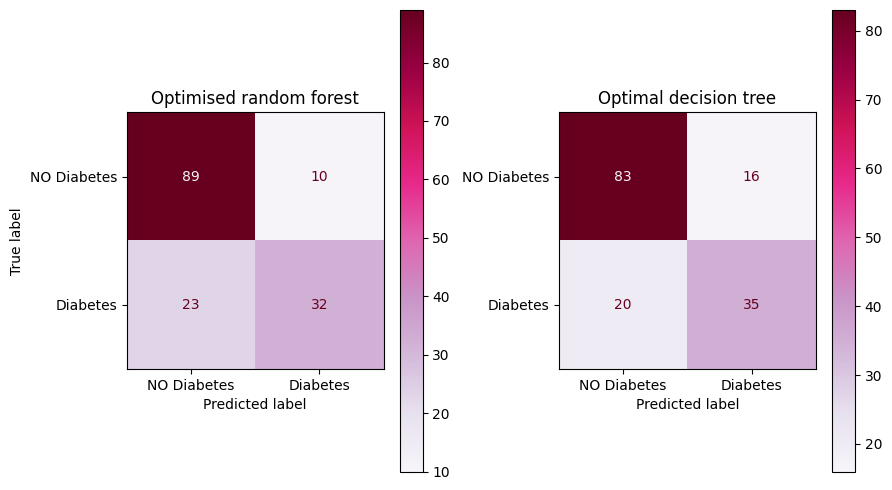

In [124]:
rf_opt_cm = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )
# plot CM
fig, ax= plt.subplots(1,2, figsize=(9,5))
rf_opt_cm.plot(cmap = 'PuRd', ax=ax[0])
ax[0].set_title('Optimised random forest')

dec_tree_cm.plot(cmap = 'PuRd', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Optimal decision tree')

plt.tight_layout()
plt.show()

**Classification report:**

For the class of patients with no-diabetes, the optimised RF performed better than the baseline RF and the optimised DT on recall although there is a mild decline in precision.

For class of patients with diabetes, the optimal RF model improved precision

In [125]:
print('Optimised decision tree clasiffication report: \n', class_report_dt)
print('Baseline random forest clasiffication report: \n', rf_class_rep_base)
print('\n Optimised random forest Clasiffication report: \n', metrics.classification_report(y_test, y_pred))

Optimised decision tree clasiffication report: 
               precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154

Baseline random forest clasiffication report: 
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


 Optimised random forest Clasiffication report: 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.76      0.58      0.66        55

    accuracy                      